In [1]:
import os
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.insert(0, r'C:\Users\USER\Desktop\CNN_GAP')
from utils.preprocess import pad_sequences
from utils.F1 import F1
from net.FS import FS
from net.FE2 import FE
from dataset.mydataset import myDataset
from scipy.signal import resample

In [2]:
Xtrain = None
with open('../Xtrain', 'rb') as fp:
    Xtrain = pickle.load(fp)

Ytrain = np.load('../Ytrain.npy')

print('# of Xtrain:', len(Xtrain))
print('Shape of Ytrain', Ytrain.shape)


# of Xtrain: 8528
Shape of Ytrain (8528,)


In [3]:
idx = np.where(Ytrain == 3)
Xtrain_won = np.delete(Xtrain, idx, axis=0)
Ytrain_won = np.delete(Ytrain, idx, axis=0)
print(Xtrain_won.shape)
print(Ytrain_won.shape)

(8244,)
(8244,)


In [4]:
Xtrain_new = []
Ytrain_new = []
cut_len = 9000
thres = 0.65
for i in range(len(Xtrain_won)):
    cut = len(Xtrain_won[i]) // cut_len
    for j in range(1, cut+1):
        Xtrain_new.append(Xtrain_won[i][(j-1)*cut_len:j*cut_len])
        Ytrain_new.append(Ytrain_won[i])        
    if len(Xtrain_won[i]) % cut_len >= int(cut_len*thres):
        x_remain = Xtrain_won[i][cut*cut_len:]
        remainder = cut_len - len(x_remain)
        Xtrain_new.append(np.pad(x_remain, (int(remainder/2), remainder - int(remainder/2)), 'constant', constant_values=0))
        Ytrain_new.append(Ytrain_won[i])

In [5]:
train_data = np.array(Xtrain_new).reshape(len(Ytrain_new),1,cut_len)
train_label = np.array(Ytrain_new)
print(train_data.shape, train_label.shape)

(8738, 1, 9000) (8738,)


In [6]:
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.3, random_state=42)
train_data = torch.from_numpy(train_data).float()
valid_data = torch.from_numpy(valid_data).float()
train_label = torch.from_numpy(train_label).long()
valid_label = torch.from_numpy(valid_label).long()
print(train_data.shape, train_label.shape, valid_data.shape, valid_label.shape)

torch.Size([6116, 1, 9000]) torch.Size([6116]) torch.Size([2622, 1, 9000]) torch.Size([2622])


In [7]:
filename = 'model4/'
file_list = os.listdir(filename)
file_list.sort()
end_name = file_list[-2].split('_')[2]

In [8]:
enc = FE(int(cut_len/8))
sel = FS()
print("Load from: ",filename+'model_enc_'+end_name)
print("Load from: ",filename+'model_sel_'+end_name)
enc.load_state_dict(torch.load(filename+'model_enc_'+end_name))
sel.load_state_dict(torch.load(filename+'model_sel_'+end_name))
enc = enc.cuda()
sel = sel.cuda()
enc = enc.eval()
sel = sel.eval()

Load from:  model4/model_enc_00093-0.93329-0.93756-0.86728-0.83723.h5
Load from:  model4/model_sel_00093-0.93329-0.93756-0.86728-0.83723.h5


In [9]:
train_data = train_data.cuda()
valid_data = valid_data.cuda()

In [10]:
type_map = ['N','A','O','~']

In [11]:

try:
    os.mkdir('GAP')
except:
    pass
try:
    os.mkdir('GAP/'+filename)
except:
    pass
try:
    os.mkdir('GAP/'+filename+'train_CAM0')
except:
    pass
try:
    os.mkdir('GAP/'+filename+'train_CAM1')
except:
    pass
try:
    os.mkdir('GAP/'+filename+'valid_CAM0')
except:
    pass
try:
    os.mkdir('GAP/'+filename+'valid_CAM1')
except:
    pass

In [12]:
def cal_CAM(i, is_train=True):
    x = None
    y = None
    if is_train:
        x, y = enc(train_data[i:i+1])
        x = sel(x)
    else:
        x, y = enc(valid_data[i:i+1])
        x = sel(x)
    predict_label = np.argmax(x.cpu().detach().numpy()[0])
    if is_train:
        weight = sel.outlayer.weight[train_label[i]].cpu().detach().numpy()    
    else:
        weight = sel.outlayer.weight[valid_label[i]].cpu().detach().numpy()  
    wave = np.zeros(int(cut_len/8))
    for idx in range(64):
        wave += (weight[idx]) * (y[:,idx].cpu().detach().numpy()[0])
    return wave, predict_label

In [13]:
def draw_CAM(idx, is_train=True):
    org = None
    wave = None
    predict_label = None
    if is_train:
        org = train_data[idx].cpu().numpy().reshape(cut_len,)
        wave, predict_label = cal_CAM(idx)
    else:
        org = valid_data[idx].cpu().numpy().reshape(cut_len,)
        wave, predict_label = cal_CAM(idx, is_train=False)
    wave = resample(wave, cut_len)
    thres = 12
    org_t = (wave > thres) * org
    org_t[org_t == 0] = None
    print('plotting index', idx)
    correct = None
    if is_train:
        correct = ((train_label[idx] == predict_label).cpu().numpy())
    else:
        correct = ((valid_label[idx] == predict_label).cpu().numpy())
    plt.clf()
    plt.subplot(3,1,1)
    plt.plot(org[2500:7500])
    plt.plot(org_t[2500:7500], 'r')
    if correct:
        plt.title('original waveform (%c)' % type_map[predict_label])
    else:
        if is_train:
            plt.title('original waveform (True label: %c, predict: %c)' % (type_map[train_label[idx]], type_map[predict_label]))
        else:
            plt.title('original waveform (True label: %c, predict: %c)' % (type_map[valid_label[idx]], type_map[predict_label]))
    plt.subplot(3,1,3)
    plt.plot(wave[2500:7500])
    plt.title('CAM')
    if is_train:
        if correct:
            plt.savefig('GAP/'+filename+'train_CAM1/'+str(idx)+'.jpg',dpi=600)
        else:
            plt.savefig('GAP/'+filename+'train_CAM0/'+str(idx)+'.jpg',dpi=600)
    else:
        if correct:
            plt.savefig('GAP/'+filename+'valid_CAM1/'+str(idx)+'.jpg',dpi=600)
        else:
            plt.savefig('GAP/'+filename+'valid_CAM0/'+str(idx)+'.jpg',dpi=600)

plotting index 0
plotting index 0
plotting index 1
plotting index 1
plotting index 2
plotting index 2
plotting index 3
plotting index 3
plotting index 4
plotting index 4
plotting index 5
plotting index 5
plotting index 6
plotting index 6
plotting index 7
plotting index 7
plotting index 8
plotting index 8
plotting index 9
plotting index 9
plotting index 10
plotting index 10
plotting index 11
plotting index 11
plotting index 12
plotting index 12
plotting index 13
plotting index 13
plotting index 14
plotting index 14
plotting index 15
plotting index 15
plotting index 16
plotting index 16
plotting index 17
plotting index 17
plotting index 18
plotting index 18
plotting index 19
plotting index 19
plotting index 20
plotting index 20
plotting index 21
plotting index 21
plotting index 22
plotting index 22
plotting index 23
plotting index 23
plotting index 24
plotting index 24
plotting index 25
plotting index 25
plotting index 26
plotting index 26
plotting index 27
plotting index 27
plotting ind

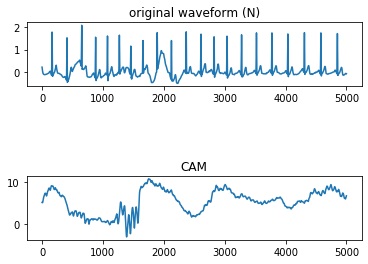

In [14]:
for idx in range(100):
    draw_CAM(idx)
    draw_CAM(idx, is_train=False)